<center> <h1> Clustering using Conditional Variational Autoencoder</h1> </center>

In [1]:
import numpy as np
import torch
import pandas as pd
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
sns.set_style('darkgrid')

In [2]:
from clustering_utils import umap,tSNE,compute_most_represented_class_per_cluster,substitute_classes_labels
from cVAE_architecture import cVAE 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128
cmap = plt.cm.get_cmap('viridis', 10)

## I. MNIST

In [3]:
# Define a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

# Create data loaders to handle batch processing
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([60000, 1, 28, 28])
Y_train shape: torch.Size([60000])
X_test shape: torch.Size([10000, 1, 28, 28])
Y_test shape: torch.Size([10000])


## I.1 Latent_dim = 16

In [4]:
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16)
autoencoder_cvae.load_state_dict(torch.load('./cVAE_models/cVAE_MNIST_zdim_16_epochs_15.pth'))

<All keys matched successfully>

Clustering using GaussianMixture

In [5]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

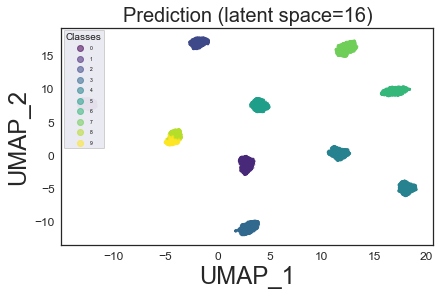

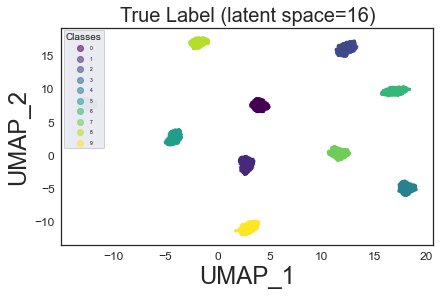

In [6]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="MNIST")

<Figure size 432x288 with 0 Axes>

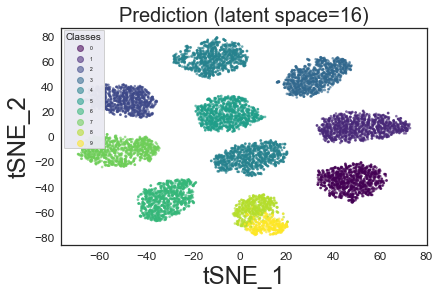

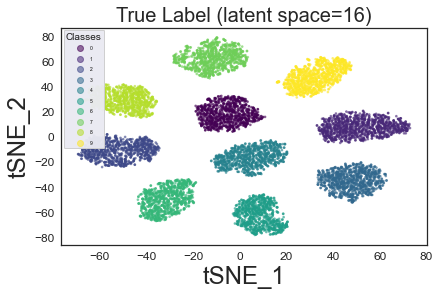

In [7]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="MNIST")

Samples of each cluster

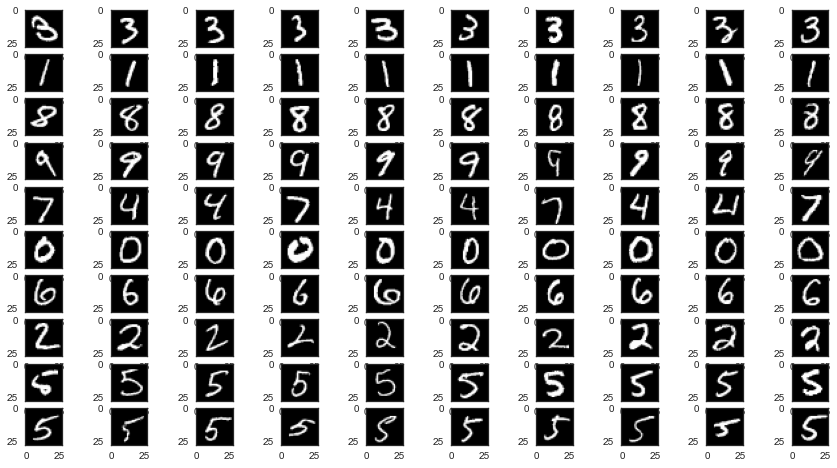

In [8]:
# Samples from each cluster
nb_samples = 10
l = list(set(y_test))

fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(15,8))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].grid(False)
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

In [9]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_16_mnist = accuracy_score(y_test, y_pred)
print(acc_16_mnist)

class_equivalence:  [3. 1. 8. 9. 7. 0. 6. 2. 5. 5.]
0.9018


In [10]:
s_16_mnist = silhouette_score(z_test, clustering_labels)
db_16_mnist = davies_bouldin_score(z_test, clustering_labels)
ch_16_mnist = calinski_harabasz_score(z_test, clustering_labels)
print(f"Silhouette: {s_16_mnist:.4f}, DB: {db_16_mnist:.4f}, CH: {ch_16_mnist:.4f}")

Silhouette: 0.2520, DB: 1.8037, CH: 1107.4440


## I.2 Latent_dim = 32

In [11]:
latent_dim = 32
autoencoder_cvae_32=cVAE(num_labels=10, latent_dim=32)
autoencoder_cvae_32.load_state_dict(torch.load('./cVAE_models/cVAE_MNIST_zdim_32_epochs_15.pth'))

<All keys matched successfully>

In [12]:
z_test = autoencoder_cvae_32.encode(X_test,Y_test)
z_train = autoencoder_cvae_32.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

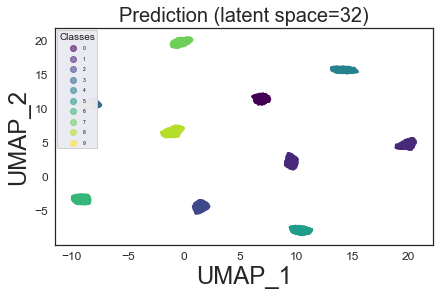

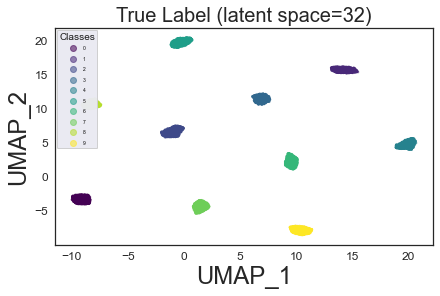

In [13]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="MNIST")

<Figure size 432x288 with 0 Axes>

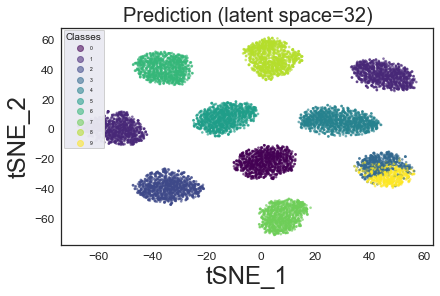

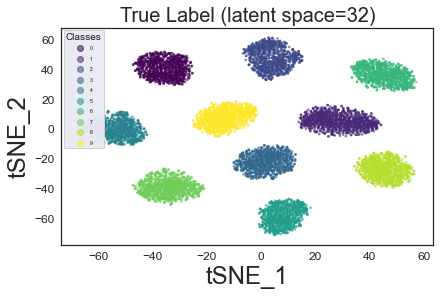

In [14]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="MNIST")

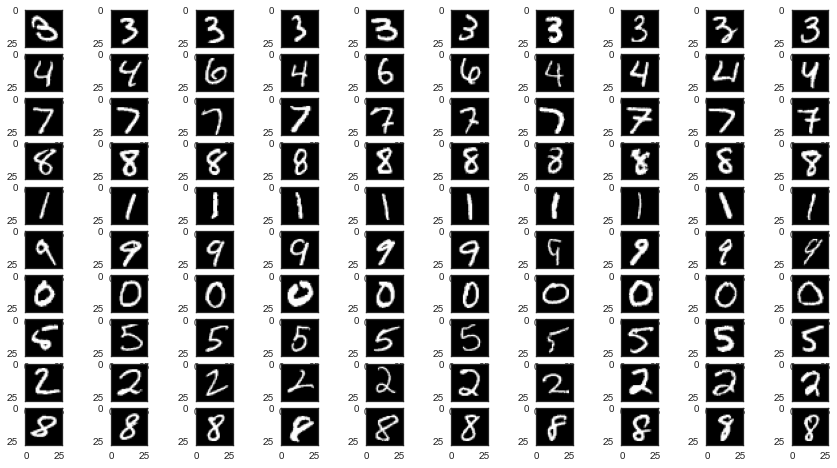

In [15]:
# Samples from each cluster
nb_samples = 10
l = list(set(y_test))

fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(15,8))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].grid(False)

plt.show()

In [16]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_32_mnist = accuracy_score(y_test, y_pred)
print("accuracy = ",acc_32_mnist)

class_equivalence:  [3. 4. 7. 8. 1. 9. 0. 5. 2. 8.]
accuracy =  0.9042


In [17]:
s_32_mnist = silhouette_score(z_test, clustering_labels)
db_32_mnist = davies_bouldin_score(z_test, clustering_labels)
ch_32_mnist = calinski_harabasz_score(z_test, clustering_labels)

print(f"Silhouette: {s_32_mnist:.4f}, DB: {db_32_mnist:.4f}, CH: {ch_32_mnist:.4f}")

Silhouette: 0.1845, DB: 2.4797, CH: 712.1826


## II. FashionMnist 

In [21]:
# Define a transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST_data', train=False, transform=transform, download=True)

# Create data loaders to handle batch processing
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([60000, 1, 28, 28])
Y_train shape: torch.Size([60000])
X_test shape: torch.Size([10000, 1, 28, 28])
Y_test shape: torch.Size([10000])


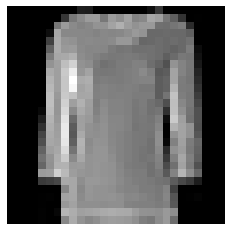

label =  tensor(0)


In [22]:
img = X_train[6][0,:,:]
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
print("label = ",Y_train[6])

## II.1 latent_dim = 16

In [23]:
latent_dim = 16
autoencoder_cvae=cVAE(num_labels=10, latent_dim=16)
autoencoder_cvae.load_state_dict(torch.load('./cVAEFM_models/cVAE_MNIST_zdim_16_epochs_25.pth'))

<All keys matched successfully>

In [24]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

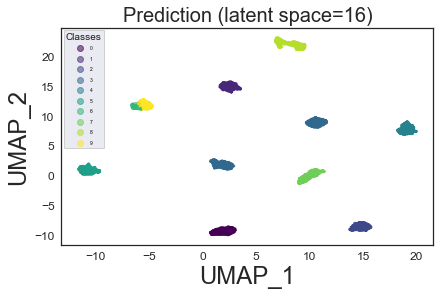

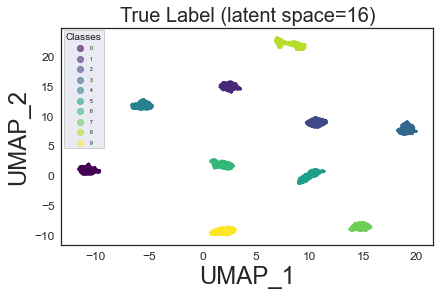

In [25]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="FashionMNIST")

<Figure size 432x288 with 0 Axes>

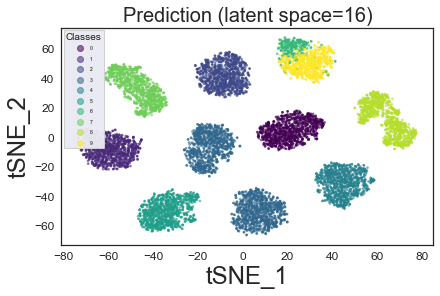

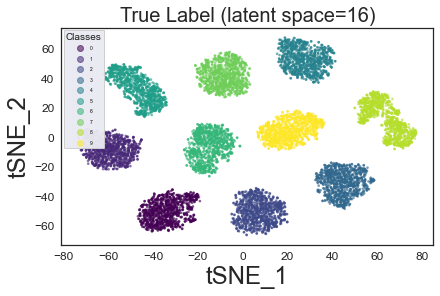

In [26]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=16,data="FashionMNIST")

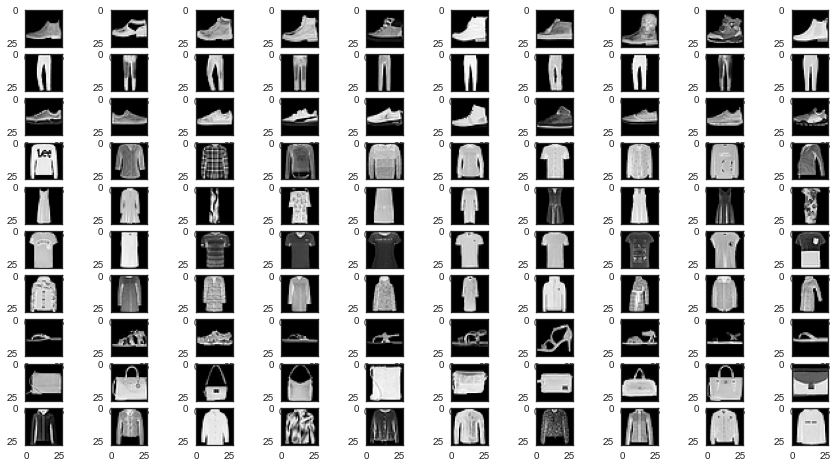

In [27]:
nb_samples = 10
l = list(set(y_test))

fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(15,8))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].grid(False)

plt.show()

In [28]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_16_fashion = accuracy_score(y_test, y_pred)
print("accuracy = ",acc_16_fashion)

class_equivalence:  [9. 1. 7. 2. 3. 0. 4. 5. 8. 4.]
accuracy =  0.9


In [29]:
s_16_fashion = silhouette_score(z_test, clustering_labels)
db_16_fashion = davies_bouldin_score(z_test, clustering_labels)
ch_16_fashion = calinski_harabasz_score(z_test, clustering_labels)

print(f"Silhouette: {s_16_fashion:.4f}, DB: {db_16_fashion:.4f}, CH: {ch_16_fashion:.4f}")

Silhouette: 0.2092, DB: 2.0235, CH: 944.5450


## II.2 latent_dim = 32

In [30]:
latent_dim = 32
autoencoder_cvae=cVAE(num_labels=10, latent_dim=32)
autoencoder_cvae.load_state_dict(torch.load('./cVAEFM_models/cVAE_MNIST_zdim_32_epochs_25.pth'))

<All keys matched successfully>

In [31]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 10
z_test = z_test.detach().numpy()
z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_train)
clustering_labels = clustering.predict(z_test)

<Figure size 432x288 with 0 Axes>

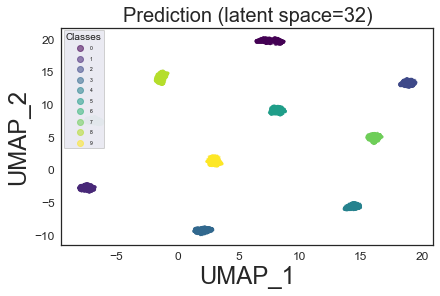

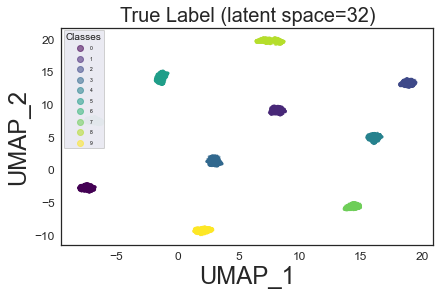

In [32]:
umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="FashionMNIST")

<Figure size 432x288 with 0 Axes>

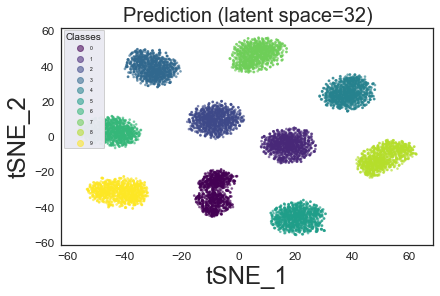

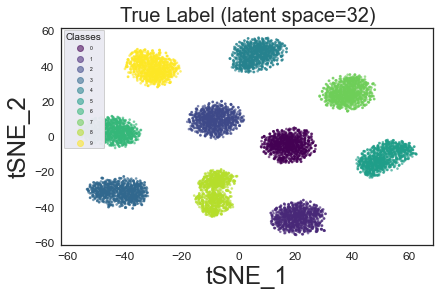

In [33]:
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,cmap=cmap,latent_space=32,data="FashionMNIST")

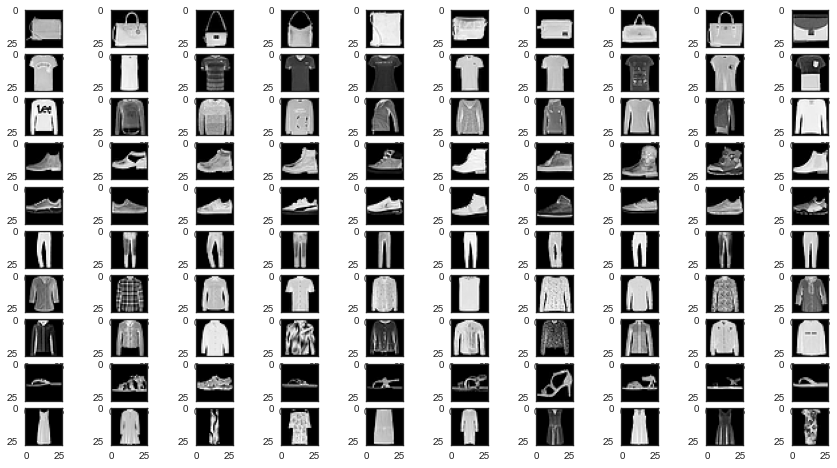

In [34]:
nb_samples = 10
l = list(set(y_test))

fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(15,8))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].grid(False)

plt.show()

In [35]:
class_equivalence = compute_most_represented_class_per_cluster(clustering_labels, y_test)
print("class_equivalence: ", class_equivalence)
y_pred = substitute_classes_labels(clustering_labels, class_equivalence)
acc_32_fashion = accuracy_score(y_test, y_pred)
print("accuracy = ",acc_32_fashion)

class_equivalence:  [8. 0. 2. 9. 7. 1. 6. 4. 5. 3.]
accuracy =  1.0


In [36]:
s_32_fashion = silhouette_score(z_test, clustering_labels)
db_32_fashion = davies_bouldin_score(z_test, clustering_labels)
ch_32_fashion = calinski_harabasz_score(z_test, clustering_labels)

print(f"Silhouette: {s_32_fashion:.4f}, DB: {db_32_fashion:.4f}, CH: {ch_32_fashion:.4f}")

Silhouette: 0.2177, DB: 1.7501, CH: 807.9427


In [37]:
print(" ")

data = {'Dataset_Z_latentDim': ['Mnist_Z_16', 'Mnist_Z_32', 'FashionMnist_Z_16', 'FashionMnist_Z_32'],
        'Accuracy': [acc_16_mnist, acc_32_mnist, acc_16_fashion, acc_32_fashion],
        'Silhouette': [s_16_mnist, s_32_mnist, s_16_fashion, s_32_fashion],
        'DB': [db_16_mnist, db_32_mnist, db_16_fashion, db_32_fashion],
        
        'CH':[ch_16_mnist, ch_32_mnist, ch_16_fashion, ch_32_fashion]}

df = pd.DataFrame(data)

print(df.to_markdown(index=False))

 
| Dataset_Z_latentDim   |   Accuracy |   Silhouette |      DB |       CH |
|:----------------------|-----------:|-------------:|--------:|---------:|
| Mnist_Z_16            |     0.9018 |     0.251985 | 1.8037  | 1107.44  |
| Mnist_Z_32            |     0.9042 |     0.184489 | 2.4797  |  712.183 |
| FashionMnist_Z_16     |     0.9    |     0.209225 | 2.02346 |  944.545 |
| FashionMnist_Z_32     |     1      |     0.217652 | 1.75011 |  807.943 |


<blockquote> 

**Silhouette Score:**
The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

**Davies-Bouldin Index:**
The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster. It evaluates both the compactness (small intra-cluster distance) and separation (large inter-cluster distance) of clusters. A lower value indicates better clustering.

**Calinski-Harabasz Index:**
The Calinski-Harabasz index, also known as the Variance Ratio Criterion, measures the ratio of between-cluster variance to within-cluster variance. It tends to be higher when clusters are well-separated and compact. A higher value suggests better clustering.

</blockquote> 